# TLDR: 
Use this notebook to run the Canopy Height Model on an input RGB image. 


# Details: 
- The input RGB image should be in topocentric coordinates, with a pixel ground sample distance (GSD) of 0.6m.
- The data type is Uint8, with nodata set to 255.
- For a ~5000x5000 image, inference runs in ~10mins on a M3 Mac.
- The final product is a geotiff of canopy height, in units of meters. Nodata is assigned as np.NaN

# Reference 
https://sustainability.atmeta.com/blog/2024/04/22/using-artificial-intelligence-to-map-the-earths-forests/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import rasterio
from rasterio.windows import Window

import torch
from torch.utils.data import DataLoader, Dataset
torch.backends.quantized.engine = 'qnnpack'
import pytorch_lightning as pl

#local modules
import sys
sys.path.append('../')
import src.transforms as transforms
import src.raster_utils as raster_utils
from inference import SSLAE

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, stack, transform=None) -> None:
        self.len = stack.shape[0]
        self.transform = transform
        self.stack = stack
        self.im_shape = stack.shape[1:]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        self.idx = idx
        im = self.stack[idx]
        if self.transform:
            im = self.transform(im)

        data = {"image": im}
        return data

In [3]:
class SSLModule3(pl.LightningModule):
    def __init__(self, path, classify=True, map_location="cpu"):
        super().__init__()
        self.translation_invariant_mse_loss = False
        ckpt = torch.load(path, map_location=map_location)
        self.chm_module_ = SSLAE(classify=classify, huge=True).eval()
        self.chm_module_ = torch.quantization.quantize_dynamic(
            self.chm_module_,
            {torch.nn.Linear, torch.nn.Conv2d, torch.nn.ConvTranspose2d},
            dtype=torch.qint8,
        )
        self.chm_module_.load_state_dict(ckpt, strict=False)

    def predict(self, batch):
        device = next(self.chm_module_.parameters()).device
        x = batch["image"].to(device)
        outputs = self.chm_module_(x)
        pred = 10 * outputs + 0.001
        pred = pred.relu()
        return pred, outputs

In [34]:
def run_inference_blocks(img, model, winsize=256):
    
    print(f"Running inference on image block of shape: {img.shape}")

    #this is how we breakup large images into batches for model inference
    step = int(winsize * 3 / 4)
    print(f"Blocking with window size: {winsize}, step: {step}")
    stack, vx, vy = raster_utils.blocking(img, (winsize, winsize, 3), step)

    transform = transforms.SSLNorm().Trans

    data = CustomImageDataset(stack, transform=transform)
    dl = DataLoader(data, shuffle=False, batch_size=stack.shape[0])
    batch = next(iter(dl))
    
    output, _ = model.predict(batch)
    weight = raster_utils.create_apodization((winsize, winsize))


    pred_stack = output.detach().numpy().squeeze()
    pred_stack = np.expand_dims(pred_stack, -1)
    out_size = img.shape[0:2]
    pred_im, weights = raster_utils.inverse_blocking(
        pred_stack, out_size, winsize, weight, step, vx, vy
    )
    pred_im = pred_im.squeeze()
    return pred_im


def windowed_infer_loop(image_path, model, out_path=None, window_size=1024):
    #suggested window sizes: 448, 1024
    if not out_path:
        out_path=image_path.replace('.tif', '_chm.tif')
    with rasterio.open(image_path) as src:
        print(f"Image size: {src.width} x {src.height}")
        meta=src.meta
        meta.update({'count':1,
                     "dtype": np.float32,
                     "driver":'GTiff',
                     "nodata": np.nan,
                     })
        with rasterio.open(out_path, 'w', **meta) as dst:
            row_coords=list(np.arange(0,src.height,window_size)[:-1])+[src.height-window_size]
            col_coords=list(np.arange(0,src.width,window_size)[:-1])+[src.width-window_size]
            for row in tqdm(row_coords, desc="inference_progress", position=0):
                for col in col_coords:
                    window = Window(col, row, window_size, window_size)
                    data = src.read(window=window)
                    mask=src.read_masks(1, window=window)
                    image = np.moveaxis(data, 0, -1)
                    chm_block=run_inference_blocks(image, model)
                    chm_block=chm_block.astype(meta['dtype'])
                    chm_block[~mask==src.nodata]=meta['nodata']
                    dst.write(chm_block, window=window, indexes=1)
            
    return out_path

In [ ]:
import os
import mercantile

folder_path = '/home/azureuser/cloudfiles/code/Users/geospatial/retro_images/chunk96'
file_names = os.listdir(folder_path)

for file_name in file_names:
    parts = file_name.split('_')

    if len(parts) < 5:
        print(f"Skipping file (unexpected format): {file_name}")
        continue

    tile_numbers = parts[1:5]
    print(f"Processing file: {file_name}")
    
    try:
        tile_pairs = [(int(tile_numbers[i]), int(tile_numbers[i+1])) for i in range(0, len(tile_numbers), 2)]
    except ValueError as e:
        print(f"Error parsing tile numbers in {file_name}: {e}")
        continue

    bounds_list = []
    for x, y in tile_pairs:
        try:
            bounds = mercantile.bounds(mercantile.Tile(x=x, y=y, z=21))
            bounds_list.append(bounds)
        except Exception as e:
            print(f"Error getting bounds for tile ({x}, {y}): {e}")

    if not bounds_list:
        print(f"No valid bounds found for {file_name}, skipping.")
        continue

    north = max(b.north for b in bounds_list)
    south = min(b.south for b in bounds_list)
    west = min(b.west for b in bounds_list)
    east = max(b.east for b in bounds_list)

    print(f"Image bounding box:")
    print(f"  Northwest corner: lat={north}, lon={west}")
    print(f"  Southeast corner: lat={south}, lon={east}")


Processing file: chunk96_396136_785760_396141_785756_z21_2016-08-28.NM.jpg
Image bounding box:
  Northwest corner: lat=41.067445419535275, lon=-111.99874877929688
  Southeast corner: lat=41.06679830722116, lon=-111.99771881103516
Processing file: chunk96_396136_785760_396141_785756_z21_2017-09-26.NM.jpg
Image bounding box:
  Northwest corner: lat=41.067445419535275, lon=-111.99874877929688
  Southeast corner: lat=41.06679830722116, lon=-111.99771881103516
Processing file: chunk96_396136_785760_396141_785756_z21_2017-10-27.NM.jpg
Image bounding box:
  Northwest corner: lat=41.067445419535275, lon=-111.99874877929688
  Southeast corner: lat=41.06679830722116, lon=-111.99771881103516
Processing file: chunk96_396136_785760_396141_785756_z21_2018-05-04.NM.jpg
Image bounding box:
  Northwest corner: lat=41.067445419535275, lon=-111.99874877929688
  Southeast corner: lat=41.06679830722116, lon=-111.99771881103516
Processing file: chunk96_396136_785760_396141_785756_z21_2018-08-29.NM.jpg
Image

# Run model on RGB demo image

In [5]:
#get model
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket='dataforgood-fb-data'
localdir='data'
s3file='forests/v1/models/saved_checkpoints/compressed_SSLhuge.pth'
local_model_file=f"{localdir}/{os.path.basename(s3file)}"
if not os.path.exists(local_model_file):
    s3_client.download_file(bucket, s3file, local_model_file)

In [6]:
#get rgb example image
#pixel size needs to be square, 0.6m GSD
#recommendation is to convert to topocentric coordinates or UTM
s3file='forests/v1/examples/CA_subset_rgb_polygon.tif'
local_rgb_file=f"{localdir}/{os.path.basename(s3file)}"
if not os.path.exists(local_rgb_file):
    s3_client.download_file(bucket, s3file, local_rgb_file)

In [11]:
from PIL import Image

# Convert PNG to TIFF
png_image_path = 'data/image.png'
tiff_image_path = 'data/image.tif'

with Image.open(png_image_path) as img:
    img.save(tiff_image_path, format='TIFF')

local_rgb_file = tiff_image_path

In [98]:
import os
import requests
from PIL import Image
import numpy as np
import rasterio
from rasterio.transform import from_origin
from dotenv import load_dotenv

load_dotenv()

def download_satellite_image_tif(lat, lon, output_dir="downloaded_images", zoom=20, size=448):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    filename = f"{lat}_{lon}_z{zoom}_{size}x{size}.tif"
    output_path = os.path.join(output_dir, filename)

    if os.path.exists(output_path):
        return output_path

    api_key = os.getenv('GOOGLE_MAPS_API_KEY')
    if not api_key:
        raise ValueError("GOOGLE_MAPS_API_KEY not found in environment variables")

    params = {
        'center': f"{lat},{lon}",
        'zoom': zoom,
        'size': f"{size}x{size}",
        'scale': 1,
        'maptype': 'satellite',
        'key': api_key,
        'format': 'png'
    }

    response = requests.get("https://maps.googleapis.com/maps/api/staticmap", params=params, timeout=30)
    response.raise_for_status()

    temp_png_path = os.path.join(output_dir, f"temp_{lat}_{lon}.png")
    with open(temp_png_path, 'wb') as f:
        f.write(response.content)

    img = Image.open(temp_png_path).convert("RGB")
    img_np = np.array(img)

    height, width, channels = img_np.shape
    transform = from_origin(0, 0, 1, 1)

    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=3,
        dtype=img_np.dtype,
        transform=transform
    ) as dst:
        for i in range(3):
            dst.write(img_np[:, :, i], i + 1)

    os.remove(temp_png_path)
    return output_path


In [99]:

tif_path = download_satellite_image_tif(39.30247393341169, -84.50006314687037)

print(f"Image saved to: {tif_path}")

Image saved to: downloaded_images/39.30247393341169_-84.50006314687037_z20_448x448.tif


In [100]:
local_rgb_file = tif_path

with rasterio.open(local_rgb_file) as src:
    rgb_shape = src.shape
    print(f"Shape of local_rgb_file: {rgb_shape}")
# TODO： 看一下local_rgb_file的shape


Shape of local_rgb_file: (448, 448)


In [45]:
#load model
model=SSLModule3(local_model_file)
model.eval();

In [82]:
chm_path=windowed_infer_loop(local_rgb_file, model, window_size=1024)

Image size: 1024 x 1024


inference_progress:   0%|          | 0/1 [00:00<?, ?it/s]

Running inference on image block of shape: (1024, 1024, 3)
Blocking with window size: 256, step: 192


In [101]:
#run model on example rgb image
chm_path=windowed_infer_loop(local_rgb_file, model, window_size=448)

Image size: 448 x 448


inference_progress:   0%|          | 0/1 [00:00<?, ?it/s]

Running inference on image block of shape: (448, 448, 3)
Blocking with window size: 256, step: 192


Text(0.5, 1.0, 'Canopy Height')

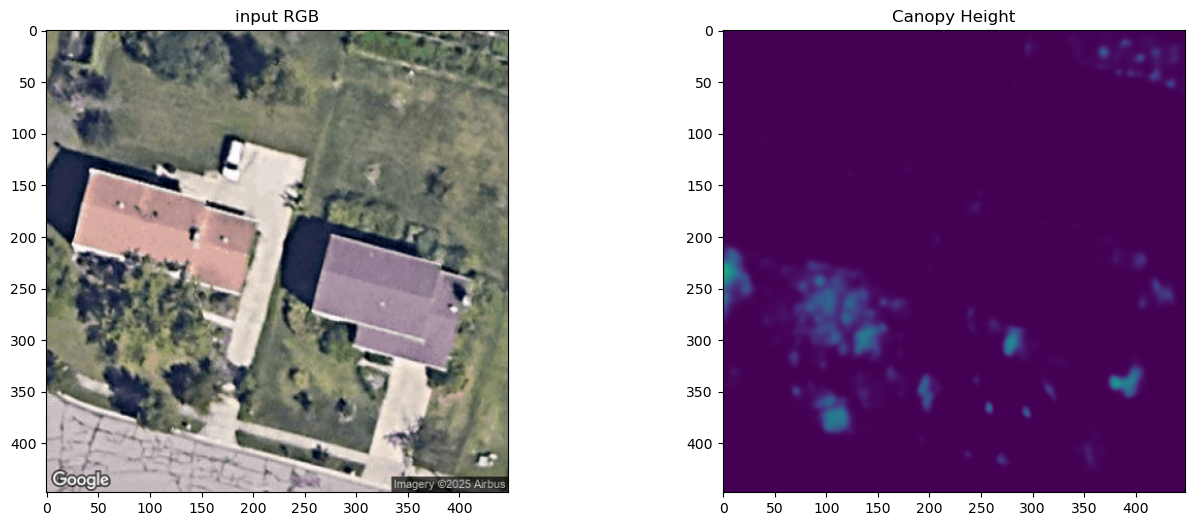

In [102]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')

In [108]:
np.max(chm)


8.833933

## Zoom 19, Image Size 448, scale 1, Window Size 448

Text(0.5, 1.0, 'Canopy Height')

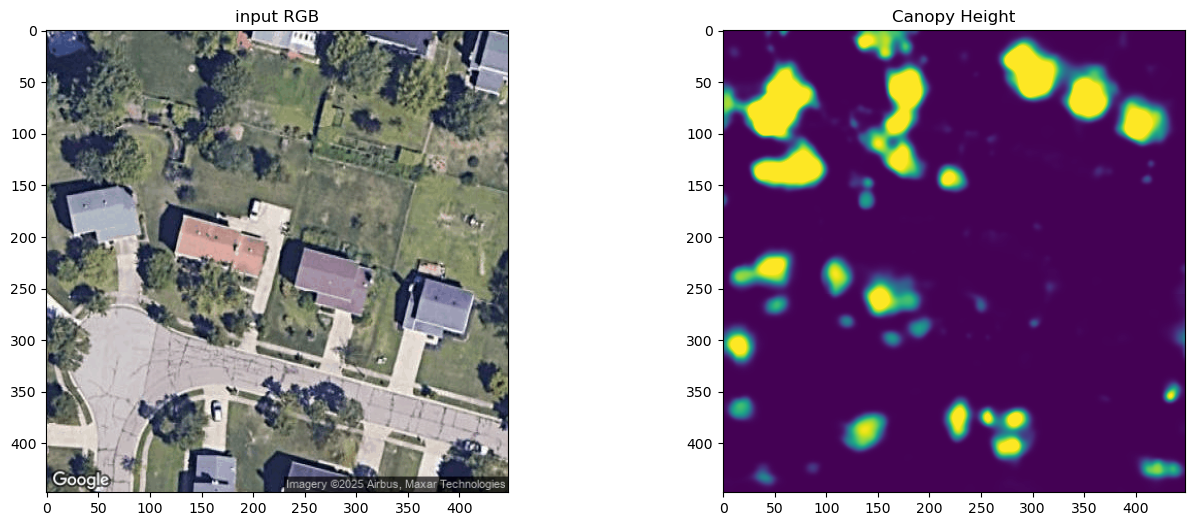

In [97]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')

## Zoom 18, Image Size 224, scale 2, Window Size 448

Text(0.5, 1.0, 'Canopy Height')

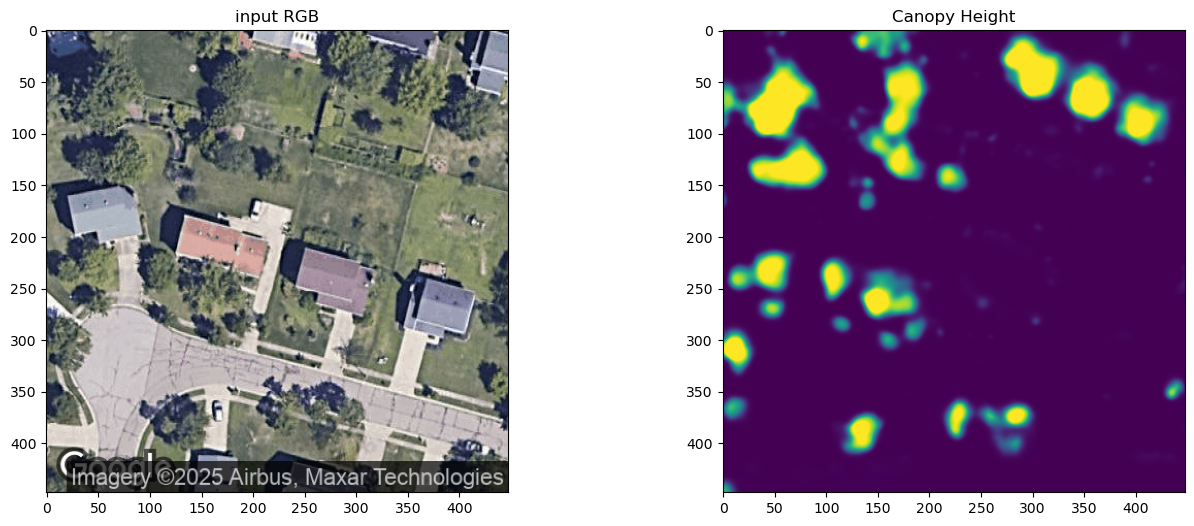

In [78]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')

## Zoom 18, Image Size 448, scale 1, Window Size 448

Text(0.5, 1.0, 'Canopy Height')

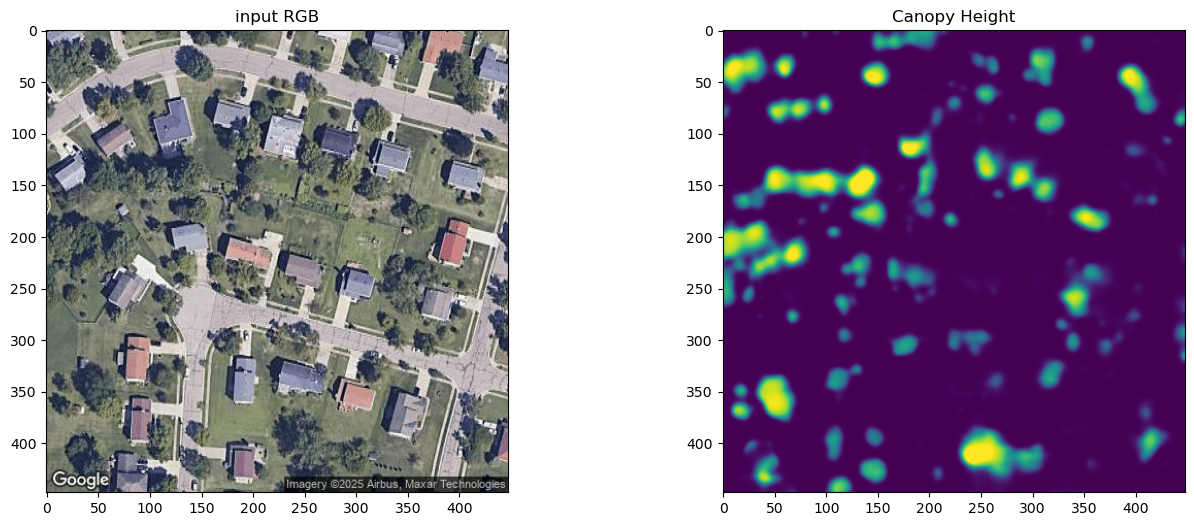

In [73]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')

## Zoom 19, Image Size 512, scale 2, Window Size 1024

In [66]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')

Text(0.5, 1.0, 'Canopy Height')

### Zoom 20， Image Size 512, scale 2, Window Size 1024

In [ ]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')

Text(0.5, 1.0, 'Canopy Height')

### Zoom 18, Image Size 512, scale 2, Window Size 1024

In [83]:
#plot result
with rasterio.open(local_rgb_file) as src:
    data=src.read()
    image = np.moveaxis(data[0:3], 0, -1)
with rasterio.open(chm_path) as src:
    chm=src.read().squeeze()
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('input RGB')
plt.subplot(1,2,2)
plt.imshow(chm, vmin=0, vmax=15)
plt.title('Canopy Height')

Text(0.5, 1.0, 'Canopy Height')